# ------------------------------------ IML vs AutoML ------------------------------------

__Introduction__  
This notebook is part of a comparative analysis between InstantML with TIM and AutoML from various other platforms. The comparison and conclusions are documented in the white paper:  TW InstantML for Time-series versus Major AutoML Offerings by Jan Dolinksy.  
For more information and details please visit www.tangent.works  

__Objective__  

  
__The notebook__  
This notebook collects the results from all experiments conducted in the platforms below using the following data sets :  
<u>Platforms::</u>
- TIM by Tangent Works
- Azure AutoML by Microsoft
- Amazon SageMaker by AWS

<u>Data sets:</u>
1. Belgian Electricity Grid  
> This data set from the energy industry is sourced directly from the Belgian Transmission System Operator (TSO) and is combined with real weather data from Belgium to show the how the different platforms react to data of a real life complex use case.  
2. Inventory Management
> The inventory management data set comes from the retail space and allows us to make a comparison with data from a different industry with a different sampling rate to see how the platforms react. This is also a rather short and stable data set so it should be fairly easy to handle.  
3. Electricity Price
> This data set again comes from the energy industry is sourced from the GEFCom competition. This data set is used to show how platforms react to more complex patterns in the data.
4. Metro Traffic
> This data set is used to showcase how the platforms react to larger datasets and longer forecasting horizons. It comes from the transportation sector and is used to forecast the number of users in a metro system.
5. Production Quality
> This dasa set is added to show how each platform finds predictive value when there are a lot more predictor candidate columns to analyze.
6. Forex  
> In this dataset, there are no predictor candidates available past the last target value. This data set shows that for other platforms it is hard to do real forecasts past the target in such scenarios without manual feature engineering or research in the use of these platforms. For TIM this is standard and straight forward.

<u>Parameters:</u>  
The following parameters are used in each platform for an accurate comparison. In order to have ensure a fair comparison, minimalistic default settings have been used meaning that in any of the platforms, the least amount of settings necessary to set up the experiment correctly have been used. In each platform, tweaking to the modeling technique is possible however then it becomes much more difficult to remain unbiased towards any platform.

| data set | Forecasting horizon | Sample rate | Rolling window | Training period | Testing period |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Belgian Electricity Grid | 24 hours | hourly | 24 | [ 2021-01-20 00:00:00 : 2021-09-28 23:00:00 ] | [ 2021-09-29 00:00:00 : 2022-01-16 23:00:00 ]
| Inventory Management | 14 days | daily | 14 | [ 2013-01-01 : 2015-01-02 ] | [ 2015-01-03 : 2015-07-31 ]
| Electricity Price | 24 hours | hourly | 24 | [ 2011-01-01 00:00:00 : 2012-12-31 23:00:00 ] | [ 2013-01-01 00:00:00 : 2013-12-16 23:00:00 ]
| Metro Traffic | 168 hours | hourly | 168 | [ 2016-01-01 00:00:00 : 2018-06-01 23:00:00 ] | [ 2018-06-02 00:00:00 : 2018-09-28 23:00:00 ]
| Production Quality | 1 hour | hourly | 1 | [ 2015-01-04 00:05:00 : 2017-05-02 23:05:00 ] | [ 2017-05-03 00:05:00 : 2018-05-03 22:05:00 ]
| Forex | 1 day | daily | 1 | [ 2010-01-04 : 2018-12-31 ] | [ 2019-01-01 : 2022-02-10 ]

For each dataset the results from the different platforms are first collected in this notebook and processed for visualization. Each dataset has a separate section below and visualize the following items:
- target value: the actual values of the target column for the testing period 
- predicted values: as calculated by the respective platforms
- MAE: this is the absolute difference between the target and predicted values (MAE = abs(target-predicted)). Actually it is the AE (Absolute Error) however this columns is usually averaged to get the Mean Absolute Error (MAE)
- Cumulative MAE: This is the cumulative sum of the MAE and shows the performance of the models over time.
- WMAPE: This is an intuitive accuracy metric to compare model performances. The WMAPE is calculated as follows: WMAPE = mean(AE)/mean(target)

The notebooks for TIM as well as the data sets (in csv) will be made available together with this comparison notebook. The notebooks from the other platforms can be shared when requested. For conclusions we refer to the whitepaper mentioned above. For further questions contact info@tangent.works .

# ---------------------- 0. Setup ----------------------

First we need to set up the necessary libraries and functions to be able to properly visualize the results

In [67]:
import pandas as pd
import os
import datetime as dt

import plotly as plt
import plotly.express as px
import plotly.graph_objects as go

In [68]:
tim_dir = './TIM Results/'
azure_dir = './Azure AutoML Results/'
amazon_dir = './Amazon SageMaker AutoML Results/'

In [69]:
def process_tim(input_df):
    output_df = input_df[input_df['forecast_type']=='OutOfSample'][['date_from','time_from','timestamp','samples_ahead','target','forecast']].reset_index(drop=True)
    output_df['datetime_from'] = pd.to_datetime(output_df['date_from']+" "+output_df['time_from'],format='%Y-%m-%d %H:%M:%S.%f')
    output_df['timestamp'] = pd.to_datetime(output_df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ')
    output_df['source'] = 'TIM'
    return output_df.drop(columns=['date_from','time_from'])

def process_automl_forecast(input_df,timestamp,target,source): 
    output_df = input_df[[timestamp,'sample',target,'predicted','datetime_from']].rename(columns={timestamp:'timestamp','sample':'samples_ahead',target:'target','predicted':'forecast'})
    output_df['timestamp'] = pd.to_datetime(output_df['timestamp'])
    output_df['datetime_from'] = pd.to_datetime(output_df['datetime_from'])
    output_df['source'] = source
    return output_df

def compare_df(df_list):
    compare_df = pd.concat(df_list)
    compare_df['MAE'] = abs(compare_df['target']-compare_df['forecast'])
    compare_df['MAPE'] = abs((compare_df['target']-compare_df['forecast'])/compare_df['target'])
    compare_df['RMSE'] = (compare_df['forecast']-compare_df['target'])**2
    compare_df['CumulMAE'] = compare_df.groupby('source').cumsum()['MAE']
    return compare_df

def pivot_df(compare_df):
    pivot_df = compare_df.pivot(index=['timestamp','target'], columns='source', values=['forecast','MAE','MAPE','RMSE','CumulMAE']).reset_index()
    pivot_df.columns = ['_'.join(col[::-1]).strip() for col in pivot_df.columns.values]
    return pivot_df

def visualize_results(v_data,title):
    x_axis = '_timestamp'
    colors = ['goldenrod','red','blue']
    fig = plt.subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.02,shared_xaxes=True)
    fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data['_target'], name='target', line=dict(color='black')), row=1, col=1)
    for c,p in enumerate(['TIM','Azure','Amazon']):
        try:
            fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_forecast'], name=p+'_forecast', line=dict(color=colors[c])), row=1, col=1)
            fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_MAE'], name=p+'_MAE', line=dict(color=colors[c])), row=2, col=1)
            fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_CumulMAE'], name=p+'_CumulMAE', line=dict(color=colors[c])), row=3, col=1)
        except:
            pass
    fig.update_layout(height=1000, width=1400, title_text=title)
    fig.show()
    
def show_accuracy(df):
    string_list = df.columns
    substring = '_MAE'
    res = [i for i in string_list if substring in i]
    mean_df = df[['_target']+res].dropna().mean()
    for acc in res: print(acc.replace('_MAE','')+' wMAPE =',mean_df[acc]/mean_df['_target'])

# ---------------------- 1. Belgian Electricity Grid ----------------------

## 1.1 Data

In [70]:
TIM_belgian_electricity_grid_df = pd.read_csv(tim_dir+'TIM_belgian_electricity_grid.csv')
Azure_belgian_electricity_grid_df = pd.read_csv(azure_dir+'Azure_belgian_electricity_grid.csv')
Amazon_belgian_electricity_grid_df = pd.read_csv(amazon_dir+'SageMaker_belgian_electricity_grid.csv',sep=";")

TIM_Grid_df = process_tim(TIM_belgian_electricity_grid_df)
Azure_Grid_df = process_automl_forecast(Azure_belgian_electricity_grid_df,'Timestamp','Quantity','Azure')
Amazon_Grid_df = process_automl_forecast(Amazon_belgian_electricity_grid_df,'Timestamp','Quantity','Amazon')

Grid_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_Grid_df,Azure_Grid_df,Amazon_Grid_df]))

## 1.2 Visual

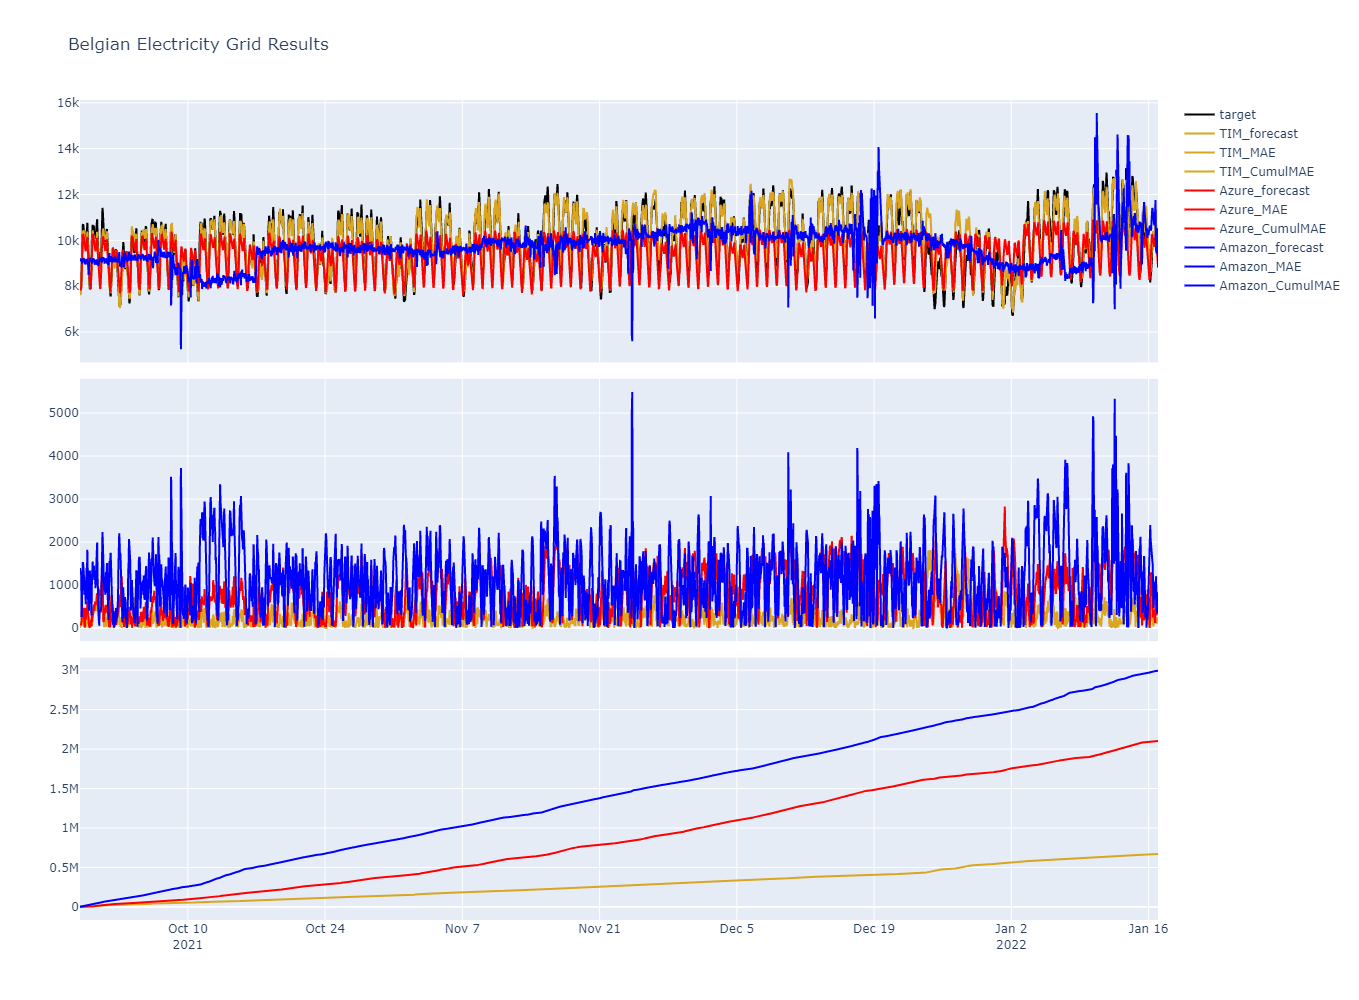

In [71]:
visualize_results(v_data=Grid_pivot_df,title="Belgian Electricity Grid Results")

__Insights__  
The forecasts clearly show that Amazon has difficulties recognizing the daily pattern and is following an average value over what looks like a weekly moving average. The results from Azure pick up on the daily pattern however there the difficulty is to pick up on the longer trends. We learn that Azure probably has overfitted on the training data and has not learned to generate accurate forecasts for wintertime. 
TIM clearly picks up both the short & long term pattern and significantly outperforms the other platforms as indicated in the cumulative MAE chart.

In [6]:
show_accuracy(Grid_pivot_df)

Amazon wMAPE = 0.11433086151281724
Azure wMAPE = 0.08030298683836333
TIM wMAPE = 0.025592892908783176


# ---------------------- 2. Inventory Management ----------------------

## 2.1 Data

In [7]:
TIM_inventory_df = pd.read_csv(tim_dir+'TIM_inventory_management.csv')
Azure_inventory_df = pd.read_csv(azure_dir+'Azure_inventory_management.csv')
Amazon_inventory_df = pd.read_csv(amazon_dir+'SageMaker_inventory_management.csv',sep=";")

TIM_invtmgmt_df = process_tim(TIM_inventory_df)
Azure_invtmgmt_df = Azure_inventory_df[['Date','sample','Sales','predicted','datetime_from']].rename(columns={'Date':'timestamp','sample':'samples_ahead','Sales':'target','predicted':'forecast'})
Azure_invtmgmt_df['source'] = 'Azure'
Azure_invtmgmt_df['timestamp'] = pd.to_datetime(Azure_invtmgmt_df['timestamp'])
Amazon_invtmgmt_df = process_automl_forecast(Amazon_inventory_df,'Date','Sales','Amazon')

invtmgmt_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_invtmgmt_df,Azure_invtmgmt_df,Amazon_invtmgmt_df]))

## 2.2 Visual

In [ ]:
visualize_results(v_data=invtmgmt_pivot_df,title="Inventory Management Results")

__Insights__  
With a more simple data set, the AutoML platforms seem to generate comparable results to TIM. Azure even outperforms TIM slightly, although the training TIM was also many times longer. The cumulative MAE also indicates that over time, TIM catches up with Azure.

In [9]:
show_accuracy(invtmgmt_pivot_df)

Amazon wMAPE = 0.12974827848094214
Azure wMAPE = 0.0833235810935559
TIM wMAPE = 0.08435044410806875


# ---------------------- 3. Electricity Price ----------------------

## 3.1 Data

In [10]:
TIM_electricity_price_df = pd.read_csv(tim_dir+'TIM_electricity_price.csv')
Azure_electricity_price_df = pd.read_csv(azure_dir+'Azure_electricity_price.csv')
Amazon_electricity_price_df = pd.read_csv(amazon_dir+'SageMaker_ElectricityPrice.csv')

TIM_elecprice_df = process_tim(TIM_electricity_price_df)
Azure_elecprice_df = process_automl_forecast(Azure_electricity_price_df,'timestamp','Price','Azure')
Amazon_elecprice_df = process_automl_forecast(Amazon_electricity_price_df,'timestamp','target','Amazon')

elecprice_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_elecprice_df,Azure_elecprice_df,Amazon_elecprice_df]))

## 3.2 Visual

In [ ]:
visualize_results(v_data=elecprice_pivot_df,title="Electricity Price Results")

__Insights__  
Again it seems that the AutoML platforms struggle with data sets with the more complex structures. Amazon again picks up on the longer term pattern whereas Azure focuses on the short term pattern. In this case, this strategy works betters for Amazon compared with the Belgian Electricity Grid data set. TIM however again dramatically outperforms the AutoML platforms leading us to conclude that these platforms are not focused on and designed for complex time series analysis but rather ML in general.

In [12]:
show_accuracy(elecprice_pivot_df)

Amazon wMAPE = 0.25867174556930633
Azure wMAPE = 0.5467608793572906
TIM wMAPE = 0.1147169229281263


# ---------------------- 4. Metro Traffic ----------------------

## 4.1 Data

In [13]:
TIM_metro_traffic_df = pd.read_csv(tim_dir+'TIM_metro_traffic.csv')
Azure_metro_traffic_df = pd.read_csv(azure_dir+'Azure_metro_traffic.csv')
Amazon_metro_traffic_df = pd.read_csv(amazon_dir+'SageMaker_MetroTraffic.csv')

TIM_metro_df = process_tim(TIM_metro_traffic_df)
Azure_metro_df = process_automl_forecast(Azure_metro_traffic_df,'date_time','traffic_volume','Azure')
Amazon_metro_df = process_automl_forecast(Amazon_metro_traffic_df,'timestamp','target','Amazon')

metro_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_metro_df,Azure_metro_df,Amazon_metro_df]))

## 4.2 Visual

In [ ]:
visualize_results(v_data=metro_pivot_df,title="Metro Traffic Results")

__Insights__  
In this example we can make similar conclusions to the inventory management dataset however now we can confirm this reaction of the modeling technique also happens with hourly data sets and longer forecasting horizons.

In [15]:
show_accuracy(metro_pivot_df)

Amazon wMAPE = 0.08519153048049616
Azure wMAPE = 0.05561804509340395
TIM wMAPE = 0.057526962832614735


# ---------------------- 5. Production Quality ----------------------

## 5.1 Data

In [16]:
TIM_production_quality_df = pd.read_csv(tim_dir+'TIM_production_quality.csv')
Azure_production_quality_df = pd.read_csv(azure_dir+'Azure_production_quality.csv')
TIM_production_quality_df['timestamp'] = pd.to_datetime(TIM_production_quality_df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ')+ dt.timedelta(minutes=5)
Azure_production_quality_df['date_time'] = pd.to_datetime(Azure_production_quality_df['date_time'])
Azure_production_quality_df['datetime_from'] = Azure_production_quality_df['date_time']-dt.timedelta(minutes=60)

TIM_production_df = process_tim(TIM_production_quality_df)
Azure_production_df = process_automl_forecast(Azure_production_quality_df,'date_time','quality','Azure')

production_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_production_df,Azure_production_df]))

## 5.2 Visual

In [ ]:
visualize_results(v_data=production_pivot_df,title="Production Quality Results")

__Insights__  
In this scenario, we were unable to generate a working model with Amazon without having to use much more computing resources. Therefore an fair default mode comparison could not be made for Amazon. To compare TIM with Azure, we see that TIM consistently outperforms Azure AutoML. 

In [18]:
show_accuracy(production_pivot_df)

Azure wMAPE = 0.021381196679998084
TIM wMAPE = 0.01572889367047635


# ---------------------- 6. Forex ----------------------

## 6.1 Data

In [19]:
TIM_forex_df = pd.read_csv(tim_dir+'TIM_forex.csv')

TIM_fx_df = process_tim(TIM_forex_df)

fx_pivot_df = pivot_df(compare_df = compare_df(df_list=[TIM_fx_df]))

## 6.2 Visual

In [ ]:
visualize_results(v_data=fx_pivot_df,title="Forex Results")

__Insights__  
In this scenario, no comparison can be made since this particular data set has no predictor candidates with data available past the last value of the target. AutoML solutions typically require a dataset where the predictor candidates are available throughout the forecasting horizon. This is however not a realistic scenario. In most real life cases, data availability is messy and therefore in order to use AutoML for time series analysis, manual feature engineering would be required. Since that would mean we are no longer comparing default settings on the same data set, no results exist for Azure & Amazon for this case.
TIM is the only platform that can generate predictions past the data availability without manual interference by the user.

In [21]:
show_accuracy(fx_pivot_df)

TIM wMAPE = 0.0020608757869838186


# ---------------------- 7. Comparison ----------------------

The visual below summarizes the accuracy values for each platform and data set. For some platforms where the calculations could not be made, the values are empty. 

In [60]:
df_list = [Grid_pivot_df,invtmgmt_pivot_df,elecprice_pivot_df,metro_pivot_df,production_pivot_df,fx_pivot_df]
name_list = ['Belgian Electricity Grid','Inventory Management','Electricity Price','Metro Traffic','Production Quality','Forex']
for c,df in enumerate(df_list):
    df['dataset']=name_list[c]
all_pivot_df = pd.concat([Grid_pivot_df,invtmgmt_pivot_df,elecprice_pivot_df,metro_pivot_df,production_pivot_df,fx_pivot_df])
melt_df = all_pivot_df.melt(id_vars=['_timestamp','_target','dataset'])
melt_df[['platform','dataType']] = melt_df['variable'].str.split('_', expand=True)
melt_df.drop(columns='variable',inplace=True)
accuracy_df = melt_df.groupby(['dataset','platform','dataType']).agg(mean_value=('value', 'mean'), max_value=('value', 'max')).reset_index()

In [66]:
rows = accuracy_df['dataset'].unique()
columns = ['MAE','MAPE','RMSE']
x_axis = 'platform'
subplot_titles = []
for i in rows:
    for j in columns: subplot_titles.append(str(i)+" "+str(j))
fig = plt.subplots.make_subplots(rows=len(rows), cols=len(columns), vertical_spacing=0.05,shared_xaxes=False,subplot_titles=subplot_titles)
for i,r in enumerate(rows):
    for j,c in enumerate(columns):
        v_data = accuracy_df[(accuracy_df['dataset']==r)&(accuracy_df['dataType']==c)]
        fig.add_trace(go.Bar(x=v_data[x_axis], y=v_data['mean_value'], name=r+'_'+c), row=i+1, col=j+1)
fig.update_layout(height=1400, width=1400, title_text='Accuracy')
fig.show()